## Notebook for using DenseNet to tell if the MCA is visible for a slice
Pipeline:
- Import data
- Find volume with the highest cumulative intensity for each patient
- Discard all other volumes
- Perform train, val, test split
- Normalize data
- Initialize model
- Train model
- Test model
- Visualize results
- Use KMeans to extract AIFs

In [1]:
# Imports
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import createImageIndexCSV, get_train_test_split_on_patients, get_max_intensity_for_dataset
from utils.model_utils import train_and_eval

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 512
EPOCHS = 50
image_path = "D:/iCAT_IMAGES"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Import images (paths)
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
# mca_labels = mca_labels[:34]
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)  # Patient 1 contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index) # Patient 11 is missing a file
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]

In [3]:
# Change the label dataframe to be compatible with efficient datahandling
mca_labels = pd.melt(mca_labels, id_vars = ['Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])

In [4]:
vol_intensities = get_max_intensity_for_dataset(image_data)

In [5]:
# Only keep the relevant volumes
from utils.datahandling_utils import filter_on_intensity_and_add_data
extra_vols = 5
copy_data = filter_on_intensity_and_add_data(image_data, mca_labels, vol_intensities, extra_vols)

Added data 1090. Original amount of data 3264


In [6]:
train_val_images, test_images = get_train_test_split_on_patients(copy_data, SEED, train_size=0.9)
train_images, val_images = get_train_test_split_on_patients(train_val_images, SEED)

In [7]:
train_labels = np.isin(mca_labels['Patient'], np.unique(train_images['Patient']))
train_labels = mca_labels[train_labels]
val_labels = np.isin(mca_labels['Patient'], np.unique(val_images['Patient']))
val_labels = mca_labels[val_labels]
test_labels = np.isin(mca_labels['Patient'], np.unique(test_images['Patient']))
test_labels = mca_labels[test_labels]

In [30]:
# Permutate labels
# train_labels['Label'] = train_labels['Label'].sample(frac=1, random_state=SEED).values
# test_labels['Label'] = test_labels['Label'].sample(frac=1, random_state=SEED).values

In [31]:
# from datahandling_utils import filter_on_intensity_and_add_data
# extra_vols = 5
# train_images = filter_on_intensity_and_add_data(train_images, train_labels, vol_intensities, extra_vols)
# test_images = filter_on_intensity_and_add_data(test_images, test_labels, vol_intensities, extra_vols)

In [8]:
label_train_true_size, label_train_size = len(train_labels[train_labels['Label'] == 1]) + len(train_images) - len(train_labels), len(train_images)
label_val_true_size, label_val_size = len(val_labels[val_labels['Label'] == 1]) + len(val_images) - len(val_labels), len(val_images)
label_test_true_size, label_test_size = len(test_labels[test_labels['Label'] == 1]) + len(test_images) - len(test_labels), len(test_images)
print(f"Size training data: {len(train_images)}. Size val_data: {len(val_images)}. Size test_data: {len(test_images)}.")
print(f"True labels in training: {label_train_true_size} of {label_train_size} ({round(label_train_true_size/label_train_size, 3)*100}%).")
print(f"True labels in val: {label_val_true_size} of {label_val_size} ({round(label_val_true_size/label_val_size, 3)*100}%)")
print(f"True labels in test: {label_test_true_size} of {label_test_size} ({round(label_test_true_size/label_test_size, 3)*100}%)")

Size training data: 3069. Size val_data: 834. Size test_data: 451.
True labels in training: 918 of 3069 (29.9%).
True labels in val: 252 of 834 (30.2%)
True labels in test: 138 of 451 (30.599999999999998%)


In [12]:
from utils.datahandling_utils import SliceIntensityDataset
train_dataset, val_dataset, test_dataset = SliceIntensityDataset(train_images, train_labels, normalize=True, crop=0.7),SliceIntensityDataset(val_images, val_labels, normalize=True, crop=0.7), SliceIntensityDataset(test_images, test_labels, normalize=True, crop=0.7)

In [13]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# TODO: Implement RayTune/Optima

In [14]:
from models.dense_net_torch import DenseNet
model = DenseNet(growth_rate=12, num_init_features = 24, bn_size = 4, drop_rate=0.4, num_classes=1)
print(f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Total number of trainable parameters 997729


In [15]:
# import torch
# torch.cuda.empty_cache()
# model.load_state_dict(torch.load('Model_128_150.pt'))
# model = model.to(device)
# model.eval()

In [16]:
losses = train_and_eval(model, train_loader, val_loader, EPOCHS, device, apr=True)

Epoch 1 of 50
Validation - Accuracy 0.69 Precision 0.0 and Recall 0.0
Training loss 0.007365048862993717, validation loss 0.0026900507509708405

Epoch 6 of 50
Validation - Accuracy 0.93 Precision 0.99 and Recall 0.79
Training loss 0.000996713642962277, validation loss 0.0007520528743043542

Epoch 11 of 50
Validation - Accuracy 0.98 Precision 0.99 and Recall 0.93
Training loss 0.0005657730507664382, validation loss 0.0002690860419534147

Epoch 16 of 50
Validation - Accuracy 0.99 Precision 0.98 and Recall 1.0
Training loss 0.0003037656715605408, validation loss 0.00015799159882590175

Epoch 21 of 50
Validation - Accuracy 0.97 Precision 0.93 and Recall 1.0
Training loss 0.0003389007761143148, validation loss 0.000291822652798146

Epoch 26 of 50
Validation - Accuracy 0.95 Precision 0.99 and Recall 0.86
Training loss 0.0001718022977001965, validation loss 0.0007018250180408359

Epoch 31 of 50
Validation - Accuracy 0.96 Precision 1.0 and Recall 0.88
Training loss 0.00012548915401566774, vali

In [39]:
from utils.model_utils import get_model_performance_metrics
print("Performance on training data:")
train_sorted = get_model_performance_metrics(model, train_images, train_labels, device, True, 0.7)
print("Performance on validation data:")
val_sorted = get_model_performance_metrics(model, val_images, val_labels, device, True, 0.7)


Performance on training data:
TP: 1026, FP: 23, TN: 2398, FN: 0
Accuracy: 0.99, Precision: 0.98, Recall: 1.0
Performance on test data:
TP: 281, FP: 10, TN: 615, FN: 1
Accuracy: 0.99, Precision: 0.97, Recall: 1.0


In [ ]:
# Saving the model:
# torch.save(model.state_dict(), f"Model_128_{EPOCHS}.pt")

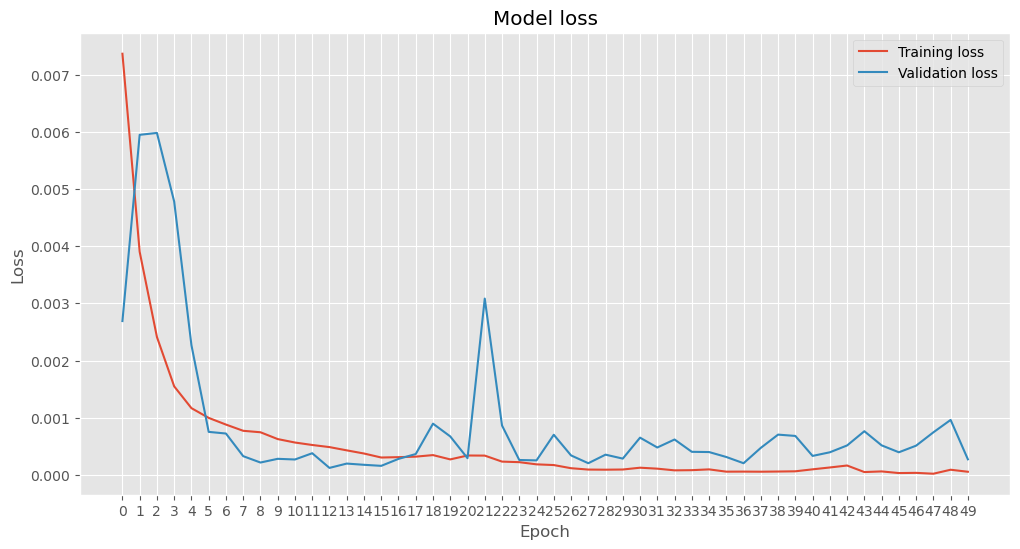

In [40]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[0][:,0], label='Training loss')
plt.plot(losses[0][:,1], label='Validation loss')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS))
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend(loc='upper right')

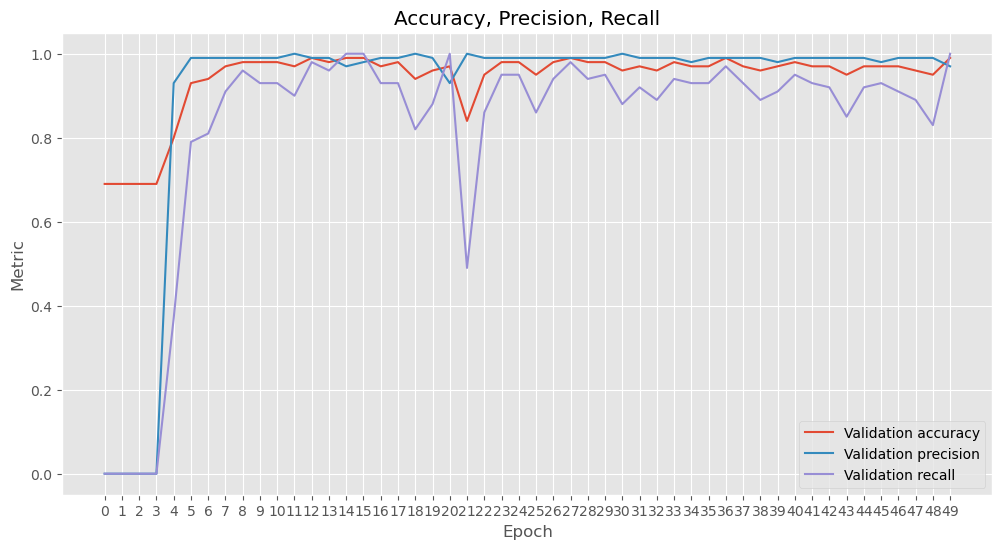

In [41]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
plt.plot(losses[1][:,0], label='Validation accuracy')
plt.plot(losses[1][:,1], label='Validation precision')
plt.plot(losses[1][:,2], label='Validation recall')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS))
plt.ylabel('Metric')
plt.title('Accuracy, Precision, Recall')
plt.legend(loc='lower right')

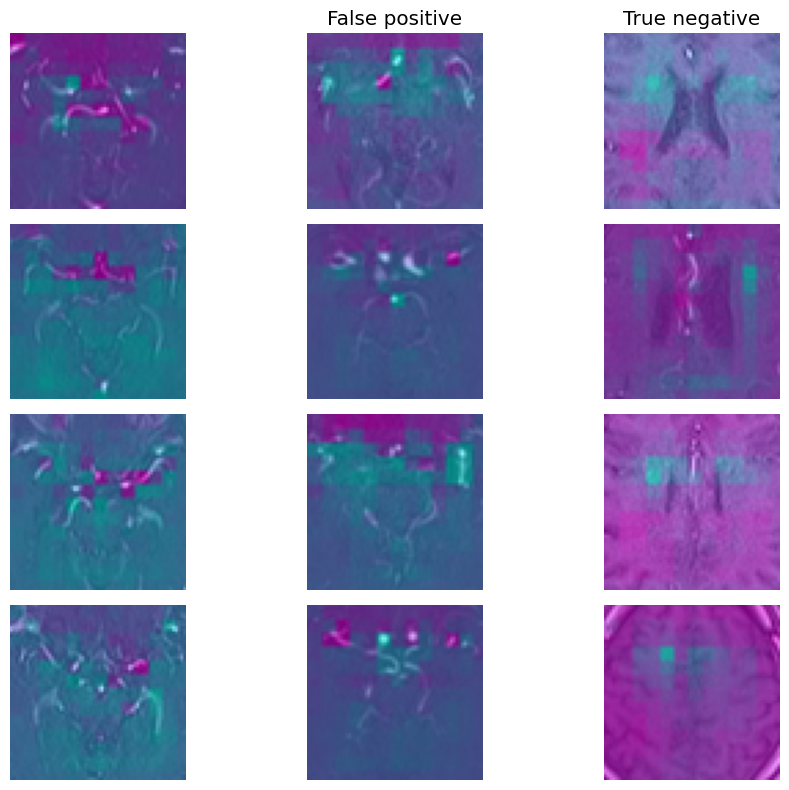

In [77]:
from utils.visualization_utils import display_predictions
display_predictions(train_sorted, model, device, True, True, 0.7)
# display_predictions(val_sorted, model, device, True, True, 0.7)


In [ ]:
val_FP, val_FN = pd.DataFrame(val_sorted[1]), pd.DataFrame(val_sorted[3])
train_FP, train_FN = pd.DataFrame(train_sorted[1]), pd.DataFrame(train_sorted[3])
name_val_slice_FP, count_val_slice_FP = np.unique(val_FP['Patient'], return_counts=True)
name_train_slice_FP, count_train_slice_FP = np.unique(train_FP['Patient'], return_counts=True)
slice_FP = {}
for i in [(name_val_slice_FP, count_val_slice_FP),(name_train_slice_FP, count_train_slice_FP)]:
    for v, c in zip(i[0],i[1]):
        if v in slice_FP:
            slice_FP[v] += c
            continue
        slice_FP[v] = c

In [ ]:
name_val_slice_FP

array([ 4,  9, 13, 14, 15, 16, 18, 27, 33, 58, 59, 60, 63, 68],
      dtype=int64)

In [ ]:
val_FP[val_FP['Patient'] == 60]

,Patient,Volume,Slice,ImagePath
229940,60,13,10,D:/iCAT_IMAGES/060/060_22_586.dcm
229941,60,13,11,D:/iCAT_IMAGES/060/060_22_587.dcm
229949,60,13,18,D:/iCAT_IMAGES/060/060_22_594.dcm
229952,60,13,21,D:/iCAT_IMAGES/060/060_22_597.dcm
229973,60,13,39,D:/iCAT_IMAGES/060/060_22_615.dcm
229974,60,13,40,D:/iCAT_IMAGES/060/060_22_616.dcm
229975,60,13,41,D:/iCAT_IMAGES/060/060_22_617.dcm
229976,60,13,42,D:/iCAT_IMAGES/060/060_22_618.dcm


In [ ]:
mca_labels[(mca_labels['Patient'] == 59) & (mca_labels['Slice']== 20)]

,Patient,Slice,Label
1348,59,20,1
